In [37]:
# load some default Python modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from datetime import datetime
import calendar
from sklearn.ensemble import RandomForestRegressor
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster
import lightgbm as lgb
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.neural_network import MLPRegressor
% matplotlib inline
plt.style.use('seaborn-whitegrid')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Training Data

In [2]:
# read data in pandas dataframe
train_df =  pd.read_csv('train.csv', nrows = 2_000_000, parse_dates=["pickup_datetime"])
# list first few rows (datapoints)
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
## Check datatypes
train_df.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [4]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


## Test data
Read the test data to check the statistics and compare with the training set.

In [5]:
# read data in pandas dataframe
test_df =  pd.read_csv('test.csv')
test_df.head(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [6]:
test_df.dtypes

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [6]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


# EDA Questions:

1.Does the number of passengers affect the fare?

2.Does the date and time of pickup affect the fare?

3.Does the day of the week affect the fare?

4.Does the distance travelled affect the fare?

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of Fare Amount')

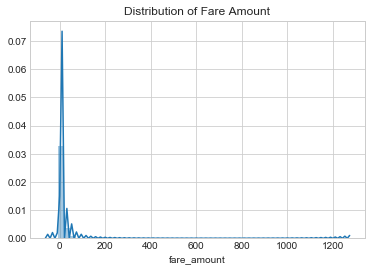

In [7]:
sns.distplot(train_df['fare_amount'])
plt.title('Distribution of Fare Amount')

<h2> First Observations while analyzing the dataset. </h2>

- The minimal `fare_amount` is negative. As this does not seem to be realistic We will drop them from the dataset.
- is there some missing data?, if so than those doesn't make sence. removing them impacts very little affect to our model.
- the minimum passenger count for some of the taxi trips are having 0 value. Zero passengers doenn't make any sense, se we are dropping those data.
- We have noticed maximum passenger count in training set more than 200, which is unreasonable so we are dropping all the taxi trips with more than 6 passenger count.
- The average `fare_amount` is about \$11.4 USD with a standard deviation of \$9.9 USD. When building a predictive model we want to be better than $9.9 USD.



<h3>    1. Removing all the taxi trips which has negative fare amount. </h3>

In [8]:
#Remove data which has the fare amount negative.
print('Old size: %d' % len(train_df))
train_df = train_df[train_df.fare_amount>=0]
print('New size: %d' % len(train_df))

Old size: 2000000
New size: 1999923



<h3>    2. Removing taxi trips having missing data.   </h3> 

Always check to see if there is missing data. As this dataset is huge, removing datapoints with missing data probably has no effect on the models beings trained.

In [9]:
#count of missing data with respect to attributes:
print(train_df.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64


In [10]:
#Removing the records with missing data.
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 1999923
New size: 1999909


<h3>    3. Removing taxi trips having passenger count less than zero and greater than six.  </h3> 

In [11]:
print('Old size: %d' % len(train_df))
train_df = train_df[train_df.passenger_count<=6]
train_df = train_df[train_df.passenger_count>0]
print('New size: %d' % len(train_df))

Old size: 1999909
New size: 1992798


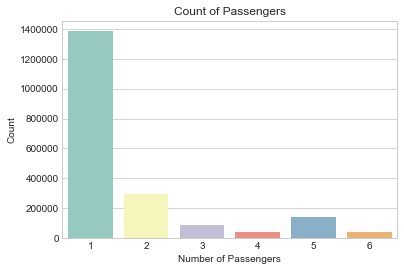

In [12]:
passenger = train_df.groupby(['passenger_count']).count()
sns.barplot(passenger.index, passenger['key'], palette = "Set3")
plt.xlabel('Number of Passengers')
plt.ylabel('Count')
plt.title('Count of Passengers')
plt.show()

In [13]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [14]:
def groupandplot(data,groupby_key,value,aggregate='mean'):
    #plt.figure(figsize=(16,10))
    agg_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+'_'+value})
    #plt.subplot(1,2,1)
    #count_data=train_df.groupby([groupby_key])['key'].count().reset_index().rename(columns={'key':'Num_Trips'})
    #sns.barplot(x=groupby_key,y='Num_Trips',data=count_data).set_title("Number of Trips vs "+groupby_key)
    
    #plt.subplot(1,2,2)
    sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=agg_data).set_title(aggregate+'_'+value+" vs "+groupby_key)

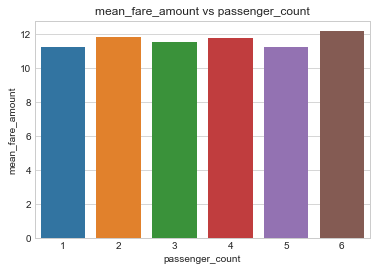

In [15]:
groupandplot(train_df,'passenger_count','fare_amount')

<h3>     4. Removing taxi trips having zero feature value which does not make sense in this dataset.

In [16]:
print('Old size: %d' % len(train_df))
train_df = train_df.loc[~(train_df == 0).any(axis=1)]
print('New size: %d' % len(train_df))

Old size: 1992798
New size: 1953476


# Converting the pickup_datetime attribute of type Object to different primitive types using lambda functions.

In [17]:
train_df['pickup_datetime']=pd.to_datetime(train_df['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')

train_df['pickup_date']= train_df['pickup_datetime'].dt.date
train_df['pickup_day']=train_df['pickup_datetime'].apply(lambda x:x.day)
train_df['pickup_hour']=train_df['pickup_datetime'].apply(lambda x:x.hour)
train_df['pickup_day_of_week']=train_df['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train_df['pickup_month']=train_df['pickup_datetime'].apply(lambda x:x.month)
train_df['pickup_year']=train_df['pickup_datetime'].apply(lambda x:x.year)

# Statistical Visualizations using Matplotlib

Text(0.5,1,'Count of Taxi Rides per Day of Week')

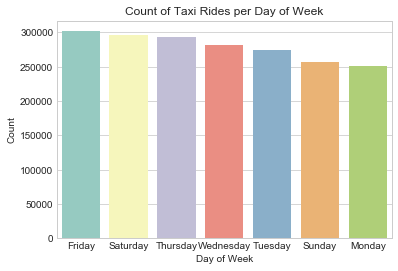

In [18]:
day_count = train_df.groupby(['pickup_day_of_week']).count().sort_values(by = 'key', ascending = False)
sns.barplot(day_count.index, day_count['key'], palette = "Set3")
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.title('Count of Taxi Rides per Day of Week')

Text(0.5,1,'Count of Taxi Rides per Day of Month')

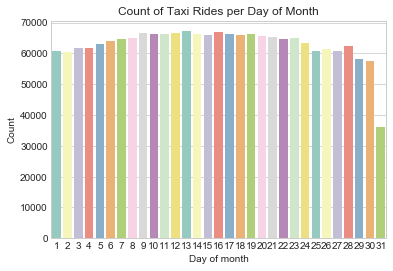

In [19]:
day_count = train_df.groupby(['pickup_day']).count().sort_values(by = 'key', ascending = False)
sns.barplot(day_count.index, day_count['key'], palette = "Set3")
plt.xlabel('Day of month')
plt.ylabel('Count')
plt.title('Count of Taxi Rides per Day of Month')

Text(0.5,1,'Average Fare Amount per Day of Week')

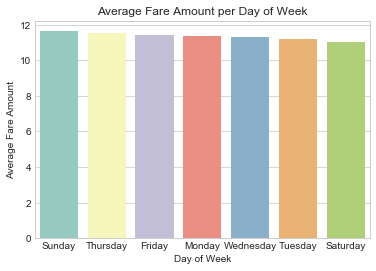

In [20]:
day_fare = train_df.groupby(['pickup_day_of_week']).mean().sort_values(by = 'fare_amount', ascending = False)

sns.barplot(day_fare.index, day_fare.fare_amount, palette = "Set3")

plt.xlabel('Day of Week')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount per Day of Week')

Text(0.5,1,'Count of Total Rides Given During Each Day')

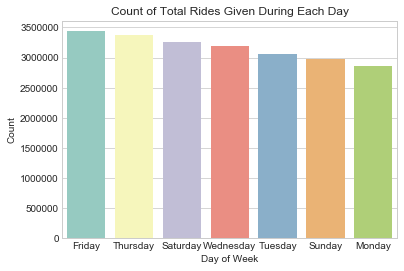

In [21]:
day_sum = train_df.groupby(['pickup_day_of_week']).sum().sort_values(by = 'fare_amount', ascending = False)

sns.barplot(day_sum.index, day_sum.fare_amount, palette = "Set3")

plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.title('Count of Total Rides Given During Each Day')

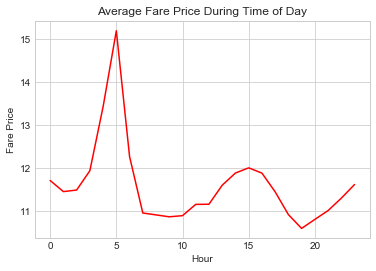

In [22]:
time_of_day = train_df.groupby(['pickup_hour']).mean()
plt.plot(time_of_day.index, time_of_day.fare_amount, color = 'r')
plt.xlabel('Hour')
plt.ylabel('Fare Price')
plt.title('Average Fare Price During Time of Day')
plt.show()

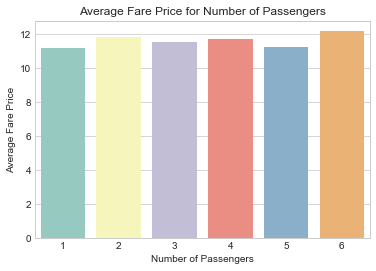

In [27]:
passenger_fare = train_df.groupby(['passenger_count']).mean()
sns.barplot(passenger_fare.index, passenger_fare['fare_amount'], palette = "Set3")
plt.xlabel('Number of Passengers')
plt.ylabel('Average Fare Price')
plt.title('Average Fare Price for Number of Passengers')
plt.show()

In [23]:
# Let us encode day of the week to numbers
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]

In [24]:
train_df['pickup_day_of_week']=train_df['pickup_day_of_week'].apply(lambda x:encodeDays(x))

In [25]:
train_df.dtypes

key                           object
fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
pickup_date                   object
pickup_day                     int64
pickup_hour                    int64
pickup_day_of_week             int64
pickup_month                   int64
pickup_year                    int64
dtype: object

In [26]:
train_df = train_df.drop(['key','pickup_datetime','pickup_date'], axis=1)
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010


## Location data

As we're dealing with location data, We want to plot the coordinates on a map. This gives a better view of the data. For this, We use the following website:

- Calculate distance between locations: https://www.travelmath.com/flying-distance/
- Open street map to grab using bouding box  a map: https://www.openstreetmap.org/export#map=8/52.154/5.295
- we have taken the boundary box [long_min, long_max, latt_min, latt_max] of New York city using website : https://www.mapdevelopers.com/geocode_bounding_box.php

North Latitude: 40.917577 South Latitude: 40.477399 East Longitude: -73.700272 West Longitude: -74.259090

This way, we are sure to train a model for the full pickup/dropoff coordinate range.

In [28]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.4729, -72.7987, 40.4901, 41.8138)
# BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('nymapzout.png')

In [29]:
print('Old size: %d' % len(train_df))
train_df = train_df[select_within_boundingbox(train_df, BB)]
print('New size: %d' % len(train_df))

Old size: 1953476
New size: 1950930


In [30]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

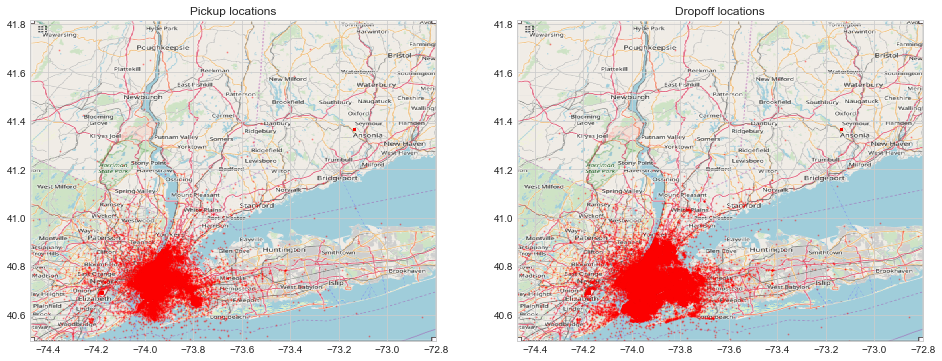

In [31]:
# plot training data on map
plot_on_map(train_df, BB, nyc_map, s=1, alpha=0.3)

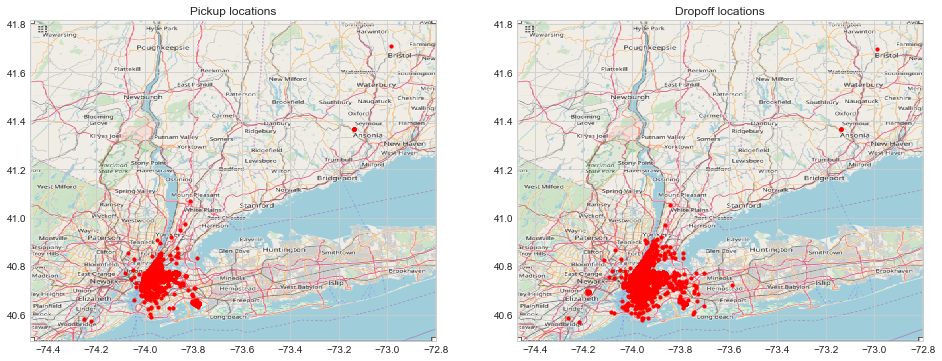

In [32]:
# plot test data on map
plot_on_map(test_df, BB, nyc_map, alpha=1.0, s=10)

In [33]:
X=train_df.drop(['fare_amount'],axis=1)
y=train_df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# Training different models to see how they perform before we get into feature engineering

In [34]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  8.333038356461138


In [35]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 883,n_jobs=-1)
rf.fit(X_train,y_train)
rf_pred= rf.predict(X_test)
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
print("RMSE for Random Forest is ",rf_rmse)

RMSE for Random Forest is  3.8946602735742886


In [36]:
train_data=lgb.Dataset(X_train,label=y_train)
param = {'num_leaves':31, 'num_trees':5000,'objective':'regression'}
param['metric'] = 'l2_root'
num_round=5000
cv_results = lgb.cv(param, train_data, num_boost_round=num_round, nfold=10,verbose_eval=20, early_stopping_rounds=20,stratified=False)
lgb_bst=lgb.train(param,train_data,len(cv_results['rmse-mean']))
lgb_pred = lgb_bst.predict(X_test)
lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, y_test))
print("RMSE for Light GBM is ",lgb_rmse)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	cv_agg's rmse: 5.13979 + 0.114765
[40]	cv_agg's rmse: 4.59172 + 0.128078
[60]	cv_agg's rmse: 4.38905 + 0.135596
[80]	cv_agg's rmse: 4.29875 + 0.134852
[100]	cv_agg's rmse: 4.24265 + 0.13626
[120]	cv_agg's rmse: 4.20154 + 0.136328
[140]	cv_agg's rmse: 4.16862 + 0.137849
[160]	cv_agg's rmse: 4.1442 + 0.139179
[180]	cv_agg's rmse: 4.12582 + 0.140582
[200]	cv_agg's rmse: 4.10664 + 0.139788
[220]	cv_agg's rmse: 4.09174 + 0.142923
[240]	cv_agg's rmse: 4.0787 + 0.144032
[260]	cv_agg's rmse: 4.06878 + 0.144377
[280]	cv_agg's rmse: 4.05915 + 0.145783
[300]	cv_agg's rmse: 4.05074 + 0.144639
[320]	cv_agg's rmse: 4.04306 + 0.142899
[340]	cv_agg's rmse: 4.03643 + 0.143336
[360]	cv_agg's rmse: 4.02875 + 0.144285
[380]	cv_agg's rmse: 4.02193 + 0.145022
[400]	cv_agg's rmse: 4.01637 + 0.145061
[420]	cv_agg's rmse: 4.01122 + 0.144808
[440]	cv_agg's rmse: 4.00717 + 0.144835
[460]	cv_agg's rmse: 4.00261 + 0.145468
[480]	cv_agg's rmse: 3.99828 + 0.146239
[500]	cv_agg's rmse: 3.99513 + 0.146804
[520]	c

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSE for Light GBM is  4.005942691695438


In [39]:
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim = 10))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 32, activation = 'relu'))


# Adding the output layer

model.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, batch_size = 100, epochs = 15)

Epoch 1/15
1560744/1560744 [==============================] - 16s 10us/step - loss: 98.7175
Epoch 2/15
1560744/1560744 [==============================] - 16s 10us/step - loss: 94.7603
Epoch 3/15
1560744/1560744 [==============================] - 16s 10us/step - loss: 94.6170
Epoch 4/15
1560744/1560744 [==============================] - 16s 10us/step - loss: 94.5452
Epoch 5/15
1560744/1560744 [==============================] - 16s 10us/step - loss: 94.5270
Epoch 6/15
1560744/1560744 [==============================] - 16s 10us/step - loss: 94.5225
Epoch 7/15
1560744/1560744 [==============================] - 16s 10us/step - loss: 94.5020
Epoch 8/15
1560744/1560744 [==============================] - 16s 10us/step - loss: 94.4977
Epoch 9/15
1560744/1560744 [==============================] - 16s 10us/step - loss: 94.4921
Epoch 10/15
1560744/1560744 [==============================] - 16s 10us/step - loss: 94.4912
Epoch 11/15
1560744/1560744 [==============================] - 16s 10us/step - 

In [40]:
y_pred1 = model.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_pred1,y_test))
rmse

9.692954298099606

In [41]:
mlp=MLPRegressor()
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [42]:
y_pred2=mlp.predict(X_test)
rmse2=np.sqrt(mean_squared_error(y_pred2,y_test))
rmse2

9.698744113571886

# This is how the dataset looks after initial analysis and feature engineering on the pickup_date_time

In [43]:
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010


# Calculate distance between coordinates with the hypothesis being fare increases with increase in distance

In [44]:
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [45]:
train_df['trip_distance']=train_df.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Distribution of Trip Distance (log scale)')

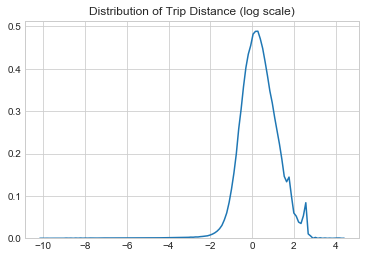

In [41]:
sns.kdeplot(np.log(train_df['trip_distance'].values)).set_title("Distribution of Trip Distance (log scale)")

Text(0,0.5,'Fare Amount')

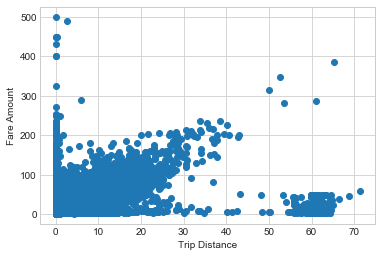

In [46]:
plt.scatter(x=train_df['trip_distance'],y=train_df['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")

In [43]:
train_df.head(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,trip_distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009,0.640487
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010,5.250670
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011,0.863411
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012,1.739386
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010,1.242218


In [47]:
long_trips=train_df[train_df['trip_distance']>=50]

In [48]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 12)

### For each pickup point add a circlemarker

for index, row in long_trips.iterrows():
    
    folium.CircleMarker([row['dropoff_latitude'], row['dropoff_longitude']],
                        radius=3,
                        color="green", 
                        fill_opacity=0.9
                       ).add_to(drop_map)
for index, row in long_trips.iterrows():
    
    folium.CircleMarker([row['pickup_latitude'], row['pickup_longitude']],
                        radius=3,
                        color="blue", 
                        fill_opacity=0.9
                       ).add_to(drop_map)
drop_map

# Fetching NYC coordinates and dividing the city into burroughs which provides us with new features being pickup and dropoff burroughs

In [49]:
nyc_boroughs={
    'manhattan':{
        'min_lng':-74.0479,
        'min_lat':40.6829,
        'max_lng':-73.9067,
        'max_lat':40.8820
    },
    
    'queens':{
        'min_lng':-73.9630,
        'min_lat':40.5431,
        'max_lng':-73.7004,
        'max_lat':40.8007

    },

    'brooklyn':{
        'min_lng':-74.0421,
        'min_lat':40.5707,
        'max_lng':-73.8334,
        'max_lat':40.7395

    },

    'bronx':{
        'min_lng':-73.9339,
        'min_lat':40.7855,
        'max_lng':-73.7654,
        'max_lat':40.9176

    },

    'staten_island':{
        'min_lng':-74.2558,
        'min_lat':40.4960,
        'max_lng':-74.0522,
        'max_lat':40.6490
        
    }  
}

In [50]:
def getBorough(lat,lng):
    
    locs=nyc_boroughs.keys()
    for loc in locs:
        if lat>=nyc_boroughs[loc]['min_lat'] and lat<=nyc_boroughs[loc]['max_lat'] and lng>=nyc_boroughs[loc]['min_lng'] and lng<=nyc_boroughs[loc]['max_lng']:
            return loc
    return 'others'

In [51]:
train_df['pickup_borough']=train_df.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
train_df['dropoff_borough']=train_df.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

# Statistical analysis of burroughs by count and also the average fare amount and distance across each burrough

Text(0.5,1,'Distribution of Pickup Boroughs')

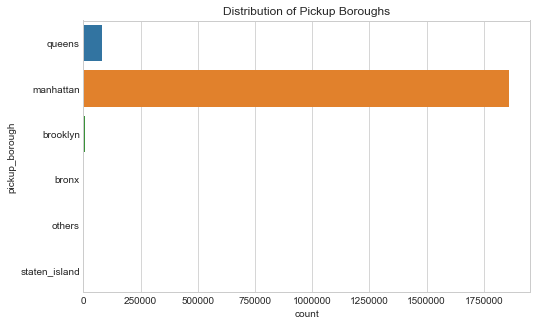

In [52]:
plt.figure(figsize=(8,5))
sns.countplot(y=train_df['pickup_borough'])
plt.title("Distribution of Pickup Boroughs")

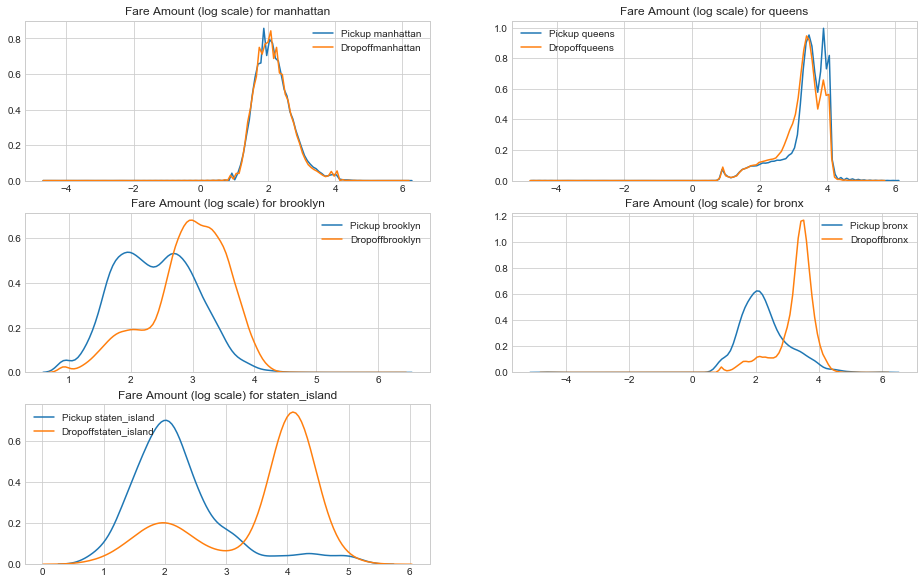

In [53]:
plt.figure(figsize=(16,10))
plt.title("Distribution of Fare Amount Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train_df.loc[train_df['pickup_borough']==key,'fare_amount'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(train_df.loc[train_df['dropoff_borough']==key,'fare_amount'].values),label='Dropoff'+ key).set_title("Fare Amount (log scale) for "+key)
    i=i+1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


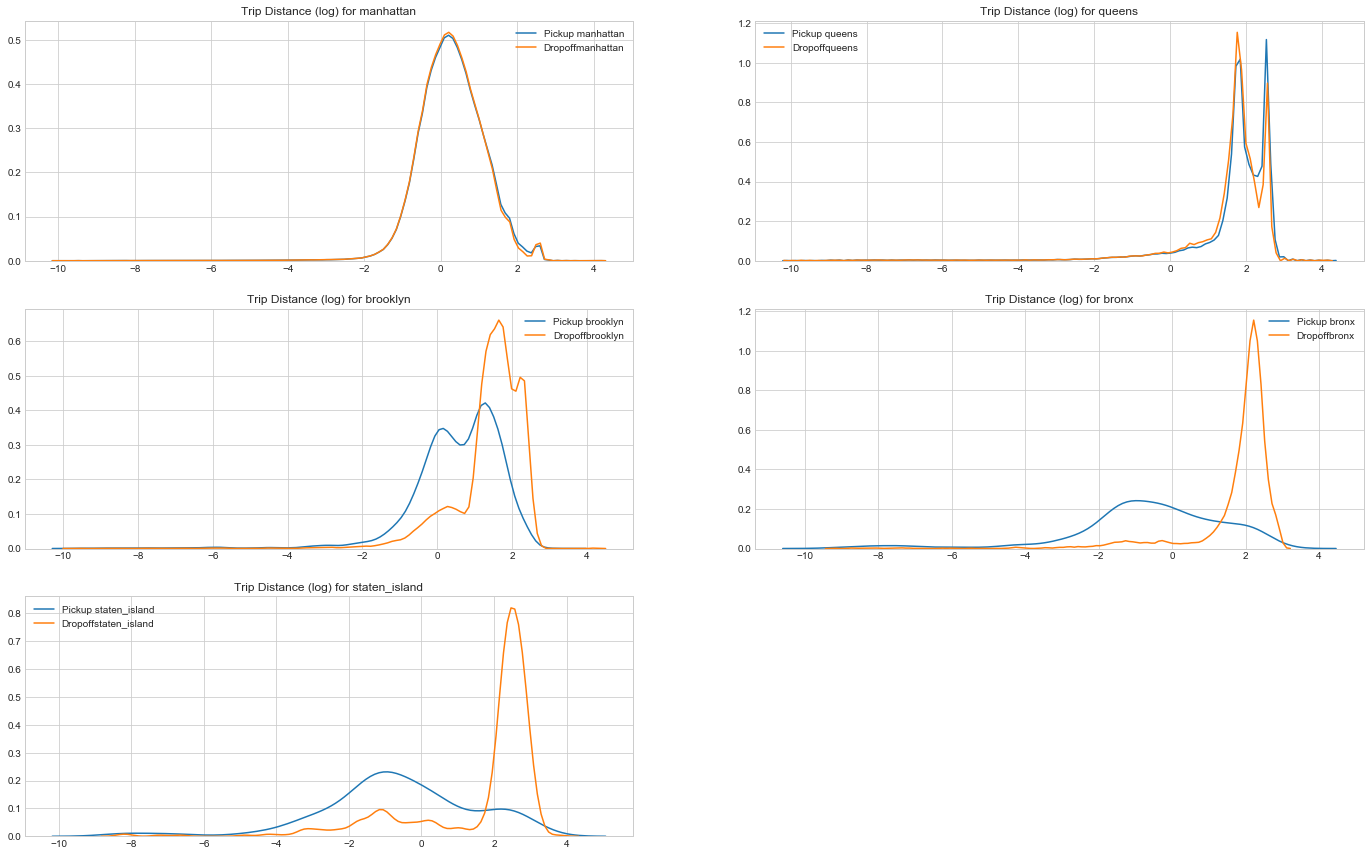

In [54]:
plt.figure(figsize=(24,15))
plt.title("Distribution of Trip Distances Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train_df.loc[train_df['pickup_borough']==key,'trip_distance'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(train_df.loc[train_df['dropoff_borough']==key,'trip_distance'].values),label='Dropoff'+ key).set_title("Trip Distance (log) for "+key)
    i=i+1

In [55]:
lower_manhattan_boundary={'min_lng': -74.0194,
                          'min_lat':40.6997,
                          'max_lng':-73.9716,
                          'max_lat':40.7427}

def isLowerManhattan(lat,lng):
    if lat>=lower_manhattan_boundary['min_lat'] and lat<=lower_manhattan_boundary['max_lat'] and lng>=lower_manhattan_boundary['min_lng'] and lng<=lower_manhattan_boundary['max_lng']:
        return 1
    else:
        return 0

In [56]:
train_df['is_pickup_lower_manhattan']=train_df.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
train_df['is_dropoff_lower_manhattan']=train_df.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [57]:
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,trip_distance,pickup_borough,dropoff_borough,is_pickup_lower_manhattan,is_dropoff_lower_manhattan
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009,0.640487,queens,queens,0,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010,5.250670,manhattan,manhattan,1,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011,0.863411,manhattan,manhattan,0,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012,1.739386,manhattan,manhattan,1,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010,1.242218,manhattan,manhattan,0,0


# Dividing trips by pickup and dropoff to airports as it was found that some coordinates having constant fare amount were the 3 airports in and around NYC

In [62]:
nyc_airports={'JFK':{'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659},
              
    'EWR':{'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        },
    'LaGuardia':{'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
        
    }
    
}
def isAirport(latitude,longitude,airport_name='JFK'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0
        

In [63]:
train_df['is_pickup_JFK']=train_df.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
train_df['is_dropoff_JFK']=train_df.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)

In [64]:
train_df['is_pickup_EWR']=train_df.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
train_df['is_dropoff_EWR']=train_df.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)

In [65]:
train_df['is_pickup_la_guardia']=train_df.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
train_df['is_dropoff_la_guardia']=train_df.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)

In [66]:
mean=np.mean(train_df['pickup_hour'].value_counts())
dev=np.std(train_df['pickup_hour'].value_counts())
taxi_count=train_df['pickup_hour'].value_counts()
m1=mean-dev
m2=mean+dev

In [67]:
from sklearn.preprocessing import LabelEncoder

number = LabelEncoder()
train_df["pickup_borough"] = number.fit_transform(train_df["pickup_borough"].astype('str'))
train_df["dropoff_borough"] = number.fit_transform(train_df["dropoff_borough"].astype('str'))

In [68]:
X=train_df.drop(['fare_amount'],axis=1)
y=train_df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# Final dataset after completing feature engineering 

In [76]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,...,pickup_borough,dropoff_borough,is_pickup_lower_manhattan,is_dropoff_lower_manhattan,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_la_guardia,is_dropoff_la_guardia
45579,-73.977442,40.777056,-73.984013,40.761130,4,3,19,0,7,2011,...,2,2,0,0,0,0,0,0,0,0
627471,-73.962375,40.769995,-73.990832,40.749810,1,11,16,4,7,2013,...,2,2,0,0,0,0,0,0,0,0
1244886,-73.979300,40.782465,-73.994103,40.736723,1,2,8,5,10,2009,...,2,2,0,1,0,0,0,0,0,0
1417202,-73.991542,40.726974,-73.977217,40.747198,1,8,3,4,1,2009,...,2,2,1,0,0,0,0,0,0,0
558935,-73.952992,40.767857,-73.959575,40.779995,6,14,8,3,8,2013,...,2,2,0,0,0,0,0,0,0,0


In [71]:
X_train.dtypes

pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
passenger_count                 int64
pickup_day                      int64
pickup_hour                     int64
pickup_day_of_week              int64
pickup_month                    int64
pickup_year                     int64
trip_distance                 float64
pickup_borough                  int64
dropoff_borough                 int64
is_pickup_lower_manhattan       int64
is_dropoff_lower_manhattan      int64
is_pickup_JFK                   int64
is_dropoff_JFK                  int64
is_pickup_EWR                   int64
is_dropoff_EWR                  int64
is_pickup_la_guardia            int64
is_dropoff_la_guardia           int64
dtype: object

In [77]:
train_data=lgb.Dataset(X_train,label=y_train)
param = {'num_leaves':31, 'num_trees':5000,'objective':'regression'}
param['metric'] = 'l2_root'
num_round=5000
cv_results = lgb.cv(param, train_data, num_boost_round=num_round, nfold=10,verbose_eval=20, early_stopping_rounds=20,stratified=False)
lgb_bst=lgb.train(param,train_data,len(cv_results['rmse-mean']))
lgb_pred = lgb_bst.predict(X_test)
lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, y_test))
print("RMSE for Light GBM is ",lgb_rmse)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	cv_agg's rmse: 4.35524 + 0.129433
[40]	cv_agg's rmse: 4.04437 + 0.140606
[60]	cv_agg's rmse: 3.96497 + 0.140757
[80]	cv_agg's rmse: 3.92378 + 0.143587
[100]	cv_agg's rmse: 3.8912 + 0.143617
[120]	cv_agg's rmse: 3.87056 + 0.142625
[140]	cv_agg's rmse: 3.85442 + 0.143535
[160]	cv_agg's rmse: 3.84004 + 0.142772
[180]	cv_agg's rmse: 3.8306 + 0.143168
[200]	cv_agg's rmse: 3.82152 + 0.144541
[220]	cv_agg's rmse: 3.81318 + 0.144338
[240]	cv_agg's rmse: 3.80683 + 0.145152
[260]	cv_agg's rmse: 3.80144 + 0.144681
[280]	cv_agg's rmse: 3.7954 + 0.145687
[300]	cv_agg's rmse: 3.79073 + 0.145711
[320]	cv_agg's rmse: 3.78711 + 0.145341
[340]	cv_agg's rmse: 3.78364 + 0.14535
[360]	cv_agg's rmse: 3.78033 + 0.145035
[380]	cv_agg's rmse: 3.77667 + 0.144612
[400]	cv_agg's rmse: 3.77346 + 0.143901
[420]	cv_agg's rmse: 3.77194 + 0.143946
[440]	cv_agg's rmse: 3.76896 + 0.144884
[460]	cv_agg's rmse: 3.76624 + 0.144195
[480]	cv_agg's rmse: 3.76403 + 0.144048
[500]	cv_agg's rmse: 3.7619 + 0.144453
[520]	cv_

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSE for Light GBM is  3.7472711240251106


In [78]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  5.1794470242162785


In [79]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 883,n_jobs=-1)
rf.fit(X_train,y_train)
rf_pred= rf.predict(X_test)
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
print("RMSE for Random Forest is ",rf_rmse)

RMSE for Random Forest is  3.8008110818608194


In [82]:
y_pred1 = model.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_pred1,y_test))
rmse

4.818148659431474

In [84]:
mlp=MLPRegressor()
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [85]:
y_pred2=mlp.predict(X_test)
rmse2=np.sqrt(mean_squared_error(y_pred2,y_test))
rmse2

4.817736259721391

In [ ]:
X_train.dtypes

In [134]:
train_df.head(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,trip_distance,pickup_borough,dropoff_borough,is_pickup_lower_manhattan,is_dropoff_lower_manhattan
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009,0.640487,4,4,0,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010,5.250670,2,2,1,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011,0.863411,2,2,0,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012,1.739386,2,2,1,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010,1.242218,2,2,0,0


In [136]:
import numpy as np
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [152]:
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim = 15))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 32, activation = 'relu'))


# Adding the output layer

model.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, batch_size = 100, epochs = 11)

Epoch 1/11
1560744/1560744 [==============================] - 8s 5us/step - loss: 54.7246
Epoch 2/11
1560744/1560744 [==============================] - 7s 5us/step - loss: 25.7808
Epoch 3/11
1560744/1560744 [==============================] - 7s 5us/step - loss: 25.2081
Epoch 4/11
1560744/1560744 [==============================] - 7s 5us/step - loss: 25.0645
Epoch 5/11
1560744/1560744 [==============================] - 7s 5us/step - loss: 24.9510
Epoch 6/11
1560744/1560744 [==============================] - 7s 5us/step - loss: 24.7079
Epoch 7/11
1560744/1560744 [==============================] - 7s 5us/step - loss: 24.4585
Epoch 8/11
1560744/1560744 [==============================] - 7s 5us/step - loss: 24.2508
Epoch 9/11
1560744/1560744 [==============================] - 7s 5us/step - loss: 24.1141
Epoch 10/11
1560744/1560744 [==============================] - 7s 5us/step - loss: 24.0220
Epoch 11/11
1560744/1560744 [==============================] - 7s 5us/step - loss: 23.9887


In [153]:
y_pred1 = model.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_pred1,y_test))
rmse

4.946160146064387

# LightGBM was found to perform best on the validation dataset with the least RMSE value

In [ ]:
test = pd.read_csv('test.csv')
In [481]:
date_columns(test)
In [484]:
test['haversine_dist']= haversine_np(test.pickup_longitude, test.pickup_latitude, test.dropoff_longitude, test.dropoff_latitude).astype(np.float32)
In [486]:
testing = test.drop(['key','pickup_datetime'], axis = 1)
In [496]:
key = test['key']
In [497]:
submission = pd.DataFrame({"key": test['key'], "fare_amount": predicted},columns = ['key','fare_amount'])
In [504]:
submission.to_csv('submission.csv', index = False)